#  AI Lab H-KA - NLP 2 -  Sentiment Analysis on Poems
> _Author: Pascal Fecht (pascal.fecht@inovex.de)_


This is the Demo for the talk _Large NLP models Transfer Learning vs. Few-Shot Learning_ of the AI lab at h-ka.


In [ ]:
!pip install datasets transformers openprompt

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

In [ ]:
from datasets import load_dataset, ClassLabel
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p "/content/gdrive/My Drive/sentiment-analysis/"
base_path = Path("/content/gdrive/My Drive/sentiment-analysis/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Dataset Loading and Preparation

Load the poem sentiment dataset from `datasets` library and prepare data.

In [ ]:
poem_sentiment = load_dataset("poem_sentiment")
poem_sentiment = poem_sentiment.rename_column("label", "labels")

  0%|          | 0/3 [00:00<?, ?it/s]

Remove label 3 (`mixed`) and cast the dataset accordingly

In [ ]:
poem_sentiment = poem_sentiment.filter(lambda x: x["labels"] != 3)
new_features = poem_sentiment['train'].features.copy()
new_features["labels"] = ClassLabel(names=["negative", "positive", "no_impact"])
poem_sentiment = poem_sentiment.cast(new_features)

In [ ]:
poem_sentiment

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'labels'],
        num_rows: 843
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'labels'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'labels'],
        num_rows: 104
    })
})

In [ ]:
poem_sentiment['train'].features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'labels': ClassLabel(num_classes=3, names=['negative', 'positive', 'no_impact'], id=None)}

In [ ]:
id2label = {
    0: "negative",
    1: "positive",
    2: "no_impact",
}
labels = list(id2label.values())

### Train split distribution

In [ ]:
df = pd.DataFrame.from_dict(poem_sentiment["train"])

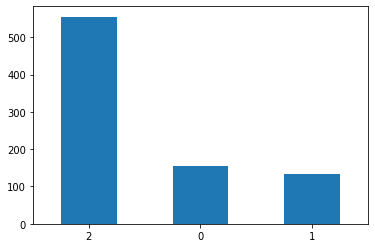

In [ ]:
df['labels'].value_counts().plot.bar(rot=0, sort_columns=True)

### Tokenization

In [ ]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenized_poem_sentiment = poem_sentiment.map(lambda example: tokenizer_bert(example["verse_text"], truncation=True), batched=True)
tokenized_poem_sentiment['train'] = tokenized_poem_sentiment['train'].remove_columns(['id', 'verse_text'])
tokenized_poem_sentiment['validation'] = tokenized_poem_sentiment['validation'].remove_columns(['id', 'verse_text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

## Fine- Tuning
In this section, we will first train a baseline model using a `roberta-base-uncased` an will use domain adapation and task-specific adapation afterwards. 

In [ ]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from datasets import load_metric
 
def compute_metrics(eval_pred):
  """ Computes the metrics given a tuple of (logits, labels) """

  load_accuracy = load_metric("accuracy")
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  load_f1 = load_metric("f1")
   
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
  precision = precision_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["precision"]
  recall = recall_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)["recall"]
  f1 = load_f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
   
  return {
    "accuracy": accuracy,
    "f1": f1,
    "precision": precision,
    "recall": recall,
  }

In [ ]:
def print_confusion_matrix(labels, predictions):
  """ Prints a confusion matrix for given labels and predictions. """
  cm = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
  disp.plot()

In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    PreTrainedModel, 
    Trainer,
    TrainingArguments, 
    PreTrainedTokenizerFast
)

In [ ]:
def setup_trainer_for_finetuning(
    model: PreTrainedModel, 
    tokenizer: PreTrainedTokenizerFast) -> Trainer:
  
  finetuning_args = TrainingArguments(
      output_dir="./results",
      learning_rate=1e-5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      num_train_epochs=10,
      weight_decay=0.01,
      warmup_ratio=0.01,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      load_best_model_at_end=True
  )
  
  return Trainer(
      model=model,
      args=finetuning_args,
      train_dataset=tokenized_poem_sentiment["train"],
      eval_dataset=tokenized_poem_sentiment["validation"],
      tokenizer=tokenizer,
      data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
      compute_metrics=compute_metrics
  )

### Baseline Model

Train a baseline model with `bert-base-uncased` for sentiment analysis.

In [ ]:
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Training

In [ ]:
trainer = setup_trainer_for_finetuning(model=bert_model, tokenizer=tokenizer_bert)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 843
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 530


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.843155,0.657143,0.264368,0.219048,0.333333
2,No log,0.690822,0.714286,0.433810,0.565657,0.438596
3,No log,0.531801,0.790476,0.615740,0.919414,0.583075
4,No log,0.401996,0.857143,0.765812,0.883266,0.716202
5,No log,0.425261,0.857143,0.772127,0.902108,0.716202
6,No log,0.348776,0.904762,0.857244,0.886233,0.837603
7,No log,0.388984,0.904762,0.850001,0.943020,0.808050
8,No log,0.423243,0.876190,0.798996,0.918499,0.764003
9,No log,0.374318,0.923810,0.886613,0.939640,0.859978
10,0.325700,0.380878,0.923810,0.886613,0.939640,0.859978


***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-53
Configuration saved in ./results/checkpoint-53/config.json
Model weights saved in ./results/checkpoint-53/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-53/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-53/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-106
Configuration saved in ./results/checkpoint-106/config.json
Model weights saved in ./results/checkpoint-106/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-106/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-106/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-159
Configuration saved in ./results/checkpoint-159/config.json
Model weights s

TrainOutput(global_step=530, training_loss=0.3091063897564726, metrics={'train_runtime': 145.108, 'train_samples_per_second': 58.095, 'train_steps_per_second': 3.652, 'total_flos': 80740360598310.0, 'train_loss': 0.3091063897564726, 'epoch': 10.0})

#### Evaluation

In [ ]:
raw_pred, _, _ = trainer.predict(tokenized_poem_sentiment['test'])
print(f"Total predictions: {len(raw_pred)}")

for text, prediction in zip(tokenized_poem_sentiment['test'], np.argmax(raw_pred, axis=1)):
    expected = text['labels']
    if expected != prediction: 
      print(f"Text: {text['verse_text']} --- Expected: {id2label[expected]} --- Predicted: {id2label[prediction]}")

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, verse_text. If id, verse_text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 104
  Batch size = 16


Total predictions: 104
Text: and be glad in the summer morning when the kindred ride on their way; --- Expected: positive --- Predicted: no_impact
Text: if they are hungry, paradise --- Expected: no_impact --- Predicted: positive
Text: how hearts were answering to his own, --- Expected: positive --- Predicted: no_impact
Text: i cannot tell rude listeners --- Expected: negative --- Predicted: no_impact
Text: crouching and sleeping neath its grassy lair, --- Expected: no_impact --- Predicted: negative
Text: sings the blackened log a tune --- Expected: no_impact --- Predicted: negative
Text: midway the floor (with thatch was it strewn) burned ever the fire-flame --- Expected: no_impact --- Predicted: negative
Text: "i rather should have hewn your limbs away, --- Expected: negative --- Predicted: no_impact
Text: a fleecy cloud, --- Expected: no_impact --- Predicted: negative
Text: shall dwell in the house of my fathers and the land of the people's praise; --- Expected: positive --- Predict

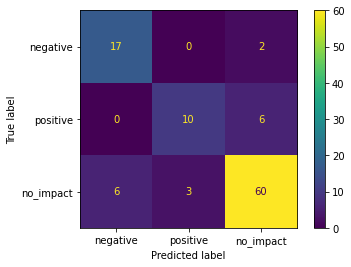

In [ ]:
predictions = np.argmax(raw_pred, axis=-1)
labels = list(tokenized_poem_sentiment['test']['labels'])
print_confusion_matrix(labels, predictions)

### Domain Adaptation

Instead of using a `bert-base-uncased` directly, let's adapt the domain to poem verses by training the MLM on a poem dataset. Afterwards, we fine-tune on `poem_sentiment` again.

#### Load and prepare dataset

In [ ]:
! gdown 1gLzA5qXV40jrmJOSZvWYrCpeLymI-Ui0

Downloading...
From: https://drive.google.com/uc?id=1gLzA5qXV40jrmJOSZvWYrCpeLymI-Ui0
To: /content/merged_data.csv
100% 11.3M/11.3M [00:00<00:00, 44.8MB/s]


In [ ]:
! wc -l /content/merged_data.csv

199003 /content/merged_data.csv


In [ ]:
! head -n 10 /content/merged_data.csv

,Verse,Meter,char_count
0,ah why this boding start this sudden pain,iambic,6
1,that wings my pulse and shoots from vein to vein,iambic,6
2,what mean regardless of yon midnight bell,iambic,6
3,these earthborn visions saddening o'er my cell,iambic,6
4,what strange disorder prompts these thoughts to glow,iambic,6
5,these sighs to murmur and these tears to flow,iambic,6
6,'tis she 'tis eloisa's form restor'd,iambic,6
7,once a pure saint and more than saints ador'd,iambic,6
8,she comes in all her killing charms confest,iambic,6


In [ ]:
poem_text_dataset = load_dataset("csv", data_files={"train": "/content/merged_data.csv"})
poem_text_dataset = poem_text_dataset['train'].train_test_split(test_size=0.1)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-37beb62e16cb49ac/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

#### Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenized_poem_text_dataset = poem_text_dataset.map(lambda examples: tokenizer(examples["Verse"], truncation=True), batched=True)

  0%|          | 0/180 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
tokenized_poem_text_dataset = tokenized_poem_text_dataset.remove_columns(['Unnamed: 0', 'Verse', 'Meter', 'char_count'])
tokenized_poem_text_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 179101
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19901
    })
})

#### MLM Training

In [ ]:
from transformers import AutoModelForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

In [ ]:
masked_lm_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
masked_mlm_args = TrainingArguments(
    output_dir=base_path / "masked-lm",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    save_steps=10000,
    load_best_model_at_end=True,
    per_device_train_batch_size=256,
)

In [ ]:
trainer = Trainer(
    model=masked_lm_model,
    args=masked_mlm_args,
    train_dataset=tokenized_poem_text_dataset["train"],
    eval_dataset=tokenized_poem_text_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 179101
  Num Epochs = 10
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 7000
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,4.201700,3.760043
2,3.885500,3.644586
3,3.688800,3.518976
4,3.618600,3.495467
5,3.544200,3.449860
6,3.542600,3.400273
7,3.502500,3.359077


***** Running Evaluation *****
  Num examples = 19901
  Batch size = 8
Saving model checkpoint to /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-700
Configuration saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-700/config.json
Model weights saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-700/pytorch_model.bin
tokenizer config file saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-700/tokenizer_config.json
Special tokens file saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-700/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 19901
  Batch size = 8
Saving model checkpoint to /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-1400
Configuration saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-1400/config.json
Model weights saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-1400/pytorch_m

Epoch,Training Loss,Validation Loss
1,4.201700,3.760043
2,3.885500,3.644586
3,3.688800,3.518976
4,3.618600,3.495467
5,3.544200,3.449860
6,3.542600,3.400273
7,3.502500,3.359077
8,3.468100,3.399629
9,3.461600,3.386003
10,3.455000,3.366681


***** Running Evaluation *****
  Num examples = 19901
  Batch size = 8
Saving model checkpoint to /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-5600
Configuration saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-5600/config.json
Model weights saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-5600/pytorch_model.bin
tokenizer config file saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-5600/tokenizer_config.json
Special tokens file saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-5600/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 19901
  Batch size = 8
Saving model checkpoint to /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-6300
Configuration saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-6300/config.json
Model weights saved in /content/gdrive/My Drive/sentiment-analysis/masked-lm/checkpoint-6300/pyto

TrainOutput(global_step=7000, training_loss=3.618254220145089, metrics={'train_runtime': 4359.0059, 'train_samples_per_second': 410.876, 'train_steps_per_second': 1.606, 'total_flos': 1.73862365514408e+16, 'train_loss': 3.618254220145089, 'epoch': 10.0})

In [ ]:
trainer.save_model(base_path / "final-masked-lm")

Saving model checkpoint to /content/gdrive/My Drive/sentiment-analysis/final-masked-lm
Configuration saved in /content/gdrive/My Drive/sentiment-analysis/final-masked-lm/config.json
Model weights saved in /content/gdrive/My Drive/sentiment-analysis/final-masked-lm/pytorch_model.bin
tokenizer config file saved in /content/gdrive/My Drive/sentiment-analysis/final-masked-lm/tokenizer_config.json
Special tokens file saved in /content/gdrive/My Drive/sentiment-analysis/final-masked-lm/special_tokens_map.json


#### Fine-Tuning the domain adapted model

In [ ]:
adapted_model = AutoModelForSequenceClassification.from_pretrained(base_path / "final-masked-lm", num_labels=3)

loading configuration file /content/gdrive/My Drive/sentiment-analysis/final-masked-lm/config.json
Model config BertConfig {
  "_name_or_path": "/content/gdrive/My Drive/sentiment-analysis/final-masked-lm",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights 

In [ ]:
trainer = setup_trainer_for_finetuning(model=adapted_model, tokenizer=tokenizer_bert)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 843
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 530
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.807921,0.657143,0.264368,0.219048,0.333333
2,No log,0.568924,0.800000,0.678221,0.842172,0.681025
3,No log,0.466986,0.847619,0.757873,0.918926,0.709307
4,No log,0.433786,0.866667,0.816611,0.880094,0.790790
5,No log,0.425222,0.885714,0.848162,0.907368,0.815229
6,No log,0.423929,0.895238,0.864256,0.911332,0.834836
7,No log,0.511630,0.857143,0.803124,0.885088,0.771182
8,No log,0.485007,0.885714,0.854531,0.896804,0.830006
9,No log,0.506321,0.885714,0.854531,0.896804,0.830006
10,0.265300,0.507991,0.876190,0.838439,0.892793,0.810398


***** Running Evaluation *****
  Num examples = 105
  Batch size = 16


Saving model checkpoint to ./results/checkpoint-53
Configuration saved in ./results/checkpoint-53/config.json
Model weights saved in ./results/checkpoint-53/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-53/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-53/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-106
Configuration saved in ./results/checkpoint-106/config.json
Model weights saved in ./results/checkpoint-106/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-106/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-106/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-159
Configuration saved in ./results/checkpoint-159/config.json
Model weights saved in ./results/checkpoint-159/pytorch_model.bin
tokenizer config fi

TrainOutput(global_step=530, training_loss=0.2513004558266334, metrics={'train_runtime': 101.1122, 'train_samples_per_second': 83.373, 'train_steps_per_second': 5.242, 'total_flos': 80740360598310.0, 'train_loss': 0.2513004558266334, 'epoch': 10.0})

#### Evaluation

In [ ]:
raw_pred, _, _ = trainer.predict(tokenized_poem_sentiment['test'])
print(f"Total predictions: {len(raw_pred)}")

for text, prediction in zip(tokenized_poem_sentiment['test'], np.argmax(raw_pred, axis=1)):
    expected = text['labels']
    if expected != prediction: 
      print(f"Text: {text['verse_text']} --- Expected: {id2label[expected]} --- Predicted: {id2label[prediction]}")

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: verse_text, id. If verse_text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 104
  Batch size = 16


Total predictions: 104
Text: lo now, o daughter of kings, let us rise in the face of the day, --- Expected: positive --- Predicted: no_impact
Text: for penance, by a saintly styrian monk --- Expected: no_impact --- Predicted: positive
Text: how hearts were answering to his own, --- Expected: positive --- Predicted: no_impact
Text: midway the floor (with thatch was it strewn) burned ever the fire-flame --- Expected: no_impact --- Predicted: negative
Text: "i rather should have hewn your limbs away, --- Expected: negative --- Predicted: no_impact
Text: shall dwell in the house of my fathers and the land of the people's praise; --- Expected: positive --- Predicted: no_impact
Text: dauntless he rose, and to the fight return’d; --- Expected: positive --- Predicted: no_impact
Text: of your strong and pliant branches, --- Expected: positive --- Predicted: no_impact
Text: (thy kingdom come) with his revealéd face --- Expected: no_impact --- Predicted: positive
Text: i see the thing as clear as

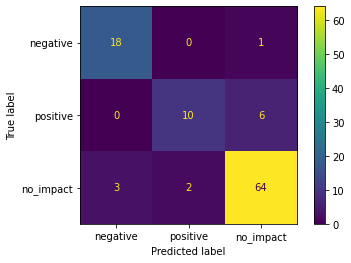

In [ ]:
predictions = np.argmax(raw_pred, axis=-1)
labels = list(tokenized_poem_sentiment['test']['labels'])
print_confusion_matrix(labels, predictions)

### Intermediate Task-Training
Using a pre-trainend sentiment model

In [ ]:
sst2_model = AutoModelForSequenceClassification.from_pretrained(
    "echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", 
    num_labels=3, 
    ignore_mismatched_sizes=True
)

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--echarlaix--bert-base-uncased-sst2-acc91.1-d37-hybrid/snapshots/f9c8e9f03396500a107dbe97024d7efa23f57e69/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = setup_trainer_for_finetuning(
    model=sst2_model, 
    tokenizer=tokenizer_bert
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 843
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 530


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.680374,0.723810,0.488314,0.510316,0.500142
2,No log,0.526745,0.800000,0.698872,0.818632,0.657334
3,No log,0.447283,0.847619,0.784168,0.847985,0.742989
4,No log,0.395195,0.838095,0.793126,0.789329,0.803787
5,No log,0.356975,0.885714,0.842133,0.861076,0.827942
6,No log,0.353548,0.895238,0.852725,0.878089,0.832772
7,No log,0.388116,0.857143,0.820001,0.807692,0.840939
8,No log,0.387435,0.876190,0.825648,0.857915,0.808334
9,No log,0.396180,0.857143,0.805556,0.822026,0.798672
10,0.283700,0.400221,0.876190,0.825648,0.857915,0.808334


***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-53
Configuration saved in ./results/checkpoint-53/config.json
Model weights saved in ./results/checkpoint-53/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-53/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-53/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-106
Configuration saved in ./results/checkpoint-106/config.json
Model weights saved in ./results/checkpoint-106/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-106/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-106/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 105
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-159
Configuration saved in ./results/checkpoint-159/config.json
Model weights s

TrainOutput(global_step=530, training_loss=0.27170356534562023, metrics={'train_runtime': 85.443, 'train_samples_per_second': 98.662, 'train_steps_per_second': 6.203, 'total_flos': 64414478102310.0, 'train_loss': 0.27170356534562023, 'epoch': 10.0})

In [ ]:
raw_pred, _, _ = trainer.predict(tokenized_poem_sentiment['test'])
print(f"Total predictions: {len(raw_pred)}")

for text, prediction in zip(tokenized_poem_sentiment['test'], np.argmax(raw_pred, axis=1)):
    expected = text['labels']
    if expected != prediction: 
      print(f"Text: {text['verse_text']} --- Expected: {id2label[expected]} --- Predicted: {id2label[prediction]}")

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: verse_text, id. If verse_text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 104
  Batch size = 16


Total predictions: 104
Text: if they are hungry, paradise --- Expected: no_impact --- Predicted: positive
Text: lo now, o daughter of kings, let us rise in the face of the day, --- Expected: positive --- Predicted: no_impact
Text: for penance, by a saintly styrian monk --- Expected: no_impact --- Predicted: negative
Text: how hearts were answering to his own, --- Expected: positive --- Predicted: no_impact
Text: sings the blackened log a tune --- Expected: no_impact --- Predicted: negative
Text: the moon hath veiled her face, --- Expected: no_impact --- Predicted: negative
Text: midway the floor (with thatch was it strewn) burned ever the fire-flame --- Expected: no_impact --- Predicted: negative
Text: "i rather should have hewn your limbs away, --- Expected: negative --- Predicted: no_impact
Text: dauntless he rose, and to the fight return’d; --- Expected: positive --- Predicted: no_impact
Text: o graves of men who lived and died --- Expected: no_impact --- Predicted: negative
Text: i

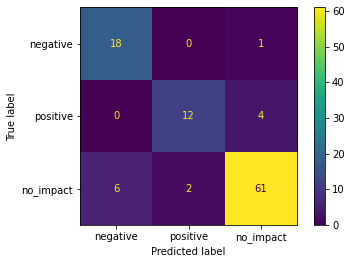

In [ ]:
predictions = np.argmax(raw_pred, axis=-1)
labels = list(tokenized_poem_sentiment['test']['labels'])
print_confusion_matrix(labels, predictions)

## Prompting

In this section, we will use `OpenPrompt` with a BERT model to classify zero-shot / few-shot.

In [ ]:
from openprompt import PromptDataLoader, PromptForClassification
from openprompt.data_utils import InputExample
from openprompt.plms import load_plm
from openprompt.prompts import ManualTemplate, ManualVerbalizer, ManualTemplate
from tqdm import tqdm
import torch

In [ ]:
torch.cuda.empty_cache()

### Model and Data Preparation

In [ ]:
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map the `poem_sentiment` dataset to a prompt dataset.

In [ ]:
from openprompt.data_utils import InputExample

dataset = {}
for split in ['train', 'validation', 'test']:
    dataset[split] = []
    for data in poem_sentiment[split]:
      dataset[split].append(
          InputExample(text_a = data['verse_text'], 
              label=int(data['labels']), 
              guid=data['id']
          )
      )

Define a method for a `PromptDataLoader` for a specific dataset split and template (see below)

In [ ]:
def get_dataloader(dataset_split, template, shuffle = False, batch_size=32):
  """ Returns a prompt data load for a given dataset split and template """

  return PromptDataLoader(
    dataset=dataset_split,
    template=template, 
    tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass, 
    shuffle=shuffle,
    truncate_method="head",
    decoder_max_length=3,
    batch_size=batch_size,
    teacher_forcing=False,
    predict_eos_token=False,
    max_seq_length=64,
  )

### Zero-Shot Learning

In zero-shot learning, we test the performance of the model without an additional information

#### Template
Define a manual template and test the it.

In [ ]:
from openprompt.prompts import ManualTemplate
template = ManualTemplate(
    text = '{"placeholder":"text_a"} It was a {"mask"} feeling.',
    tokenizer = tokenizer,
)

In [ ]:
wrapped_example = template.wrap_one_example(dataset['train'][0])
print(wrapped_example)

[[{'text': 'with pale blue berries. in these peaceful shades--', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was a', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' feeling.', 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 0, 'label': 1}]


#### Verbalizer

Define manual words / terms that refer to each class.

In [ ]:
# It was a ... feeling.
label2answer = {
  0: ["bad", "horrible"], # "negative", "nasty", "poor", "guilty"],
  1: ["fantastic", "good"], # , "wonderful", "terrific", "great"],
  2: ["neutral", "common"] # , "regular", "habitual", "usual"],
}

In [ ]:
verbalizer = ManualVerbalizer(
    classes=[0, 1, 2],
    label_words=label2answer,
    tokenizer=tokenizer
)

#### Evaluation



In [ ]:
prompt_model = PromptForClassification(
    template=template,
    plm=plm,
    verbalizer=verbalizer,
    freeze_plm = False
)
prompt_model = prompt_model.cuda()

In [ ]:
test_dataloader = get_dataloader(dataset["test"], template)

tokenizing: 104it [00:00, 1212.73it/s]


In [ ]:
def evaluate(data_loader, prompt_model, desc="Validation"):
  prompt_model.eval()
  all_logits = []
  all_labels = []
  with torch.no_grad():
    for inputs in tqdm(data_loader, desc="Validation"):
        inputs = inputs.cuda()
        logits = prompt_model(inputs)
        all_logits.extend(logits.cpu().tolist())
        all_labels.extend(inputs['label'].cpu().tolist())
  return (all_logits, all_labels)

In [ ]:
eval_pred = evaluate(test_dataloader, prompt_model)
logits, labels = eval_pred

Validation: 100%|██████████| 4/4 [00:00<00:00, 15.29it/s]


In [ ]:
compute_metrics(eval_pred)

{'accuracy': 0.3076923076923077,
 'f1': 0.3390262172284644,
 'precision': 0.25128884960966263,
 'recall': 0.6107456140350878}

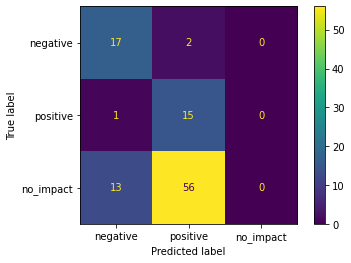

In [ ]:
print_confusion_matrix(labels, np.argmax(logits, axis=-1))

### Prompt-Based Fine-Tuning

In [ ]:
epochs = 3

In [ ]:
train_dataloader = get_dataloader(dataset['train'], template, shuffle=True)
validation_dataloader = get_dataloader(dataset['validation'], template, shuffle=False)

tokenizing: 843it [00:00, 1140.94it/s]
tokenizing: 105it [00:00, 1274.18it/s]


In [ ]:
from transformers import  AdamW, get_linear_schedule_with_warmup
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']

# it's always good practice to set no decay to biase and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in prompt_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

for epoch in range(epochs):
    tot_loss = 0
    for inputs in tqdm(train_dataloader, desc=f"Epoch {epoch}\t"):
        inputs = inputs.cuda()
        logits = prompt_model(inputs)
        labels = inputs['label']
        loss = loss_func(logits, labels)
        loss.backward()
        tot_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    
    eval_pred = evaluate(validation_dataloader, prompt_model, desc=f"Val epoch {epoch}")
    f1 = compute_metrics(eval_pred)['f1']
    print(f"\nEpoch {epoch+1}, train loss: {tot_loss/(len(train_dataloader)+1)}, val f1: {f1}\n", flush=True)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Validation: 100%|██████████| 4/4 [00:00<00:00, 16.44it/s]



Epoch 1, train loss: 0.7437421594347272, val f1: 0.7321132767941277



Validation: 100%|██████████| 4/4 [00:00<00:00, 16.19it/s]



Epoch 2, train loss: 0.18516549162034476, val f1: 0.7802252816020024



Validation: 100%|██████████| 4/4 [00:00<00:00, 16.10it/s]



Epoch 3, train loss: 0.03742532921023667, val f1: 0.7822222222222223



#### Evaluation

In [ ]:
eval_pred = evaluate(test_dataloader, prompt_model)
logits, labels = eval_pred

Validation: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s]


In [ ]:
compute_metrics(eval_pred)

{'accuracy': 0.8942307692307693,
 'f1': 0.8542421854478591,
 'precision': 0.8896705146705147,
 'recall': 0.8381324688532926}

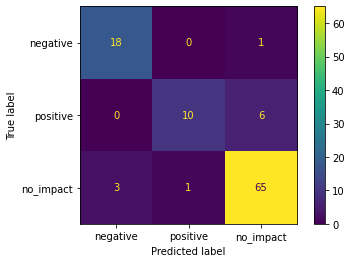

In [ ]:
print_confusion_matrix(labels, np.argmax(logits, axis=-1))

### Soft Verbalizer

In [ ]:
from openprompt.prompts import SoftVerbalizer

In [ ]:
soft_verbalizer = SoftVerbalizer(tokenizer, plm, num_classes=3)

In [ ]:
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-uncased")
prompt_model = PromptForClassification(plm=plm,template=template, verbalizer=soft_verbalizer, freeze_plm=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
epochs = 5

#### Training

In [ ]:
prompt_model = prompt_model.cuda()

In [ ]:
from transformers import  AdamW, get_linear_schedule_with_warmup
loss_func = torch.nn.CrossEntropyLoss()

no_decay = ['bias', 'LayerNorm.weight']

# it's always good practice to set no decay to biase and LayerNorm parameters
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in prompt_model.plm.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# Using different optimizer for prompt parameters and model parameters

optimizer_grouped_parameters2 = [
    {'params': prompt_model.verbalizer.group_parameters_1, "lr":3e-5},
    {'params': prompt_model.verbalizer.group_parameters_2, "lr":3e-4},
]


optimizer1 = AdamW(optimizer_grouped_parameters1, lr=3e-5)
optimizer2 = AdamW(optimizer_grouped_parameters2)

for epoch in range(epochs):
    tot_loss = 0
    for inputs in tqdm(train_dataloader, desc=f"Epoch {epoch}\t"):
        inputs = inputs.cuda()
        logits = prompt_model(inputs)
        labels = inputs['label']
        loss = loss_func(logits, labels)
        loss.backward()
        tot_loss += loss.item()
        optimizer1.step()
        optimizer1.zero_grad()
        optimizer2.step()
        optimizer2.zero_grad()
  
    eval_pred = evaluate(validation_dataloader, prompt_model, desc=f"Val epoch {epoch}")
    f1 = compute_metrics(eval_pred)['f1']
    print(f"\nEpoch {epoch+1}, train loss: {tot_loss/(len(train_dataloader)+1)}, val f1: {f1}\n", flush=True)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Validation: 100%|██████████| 4/4 [00:00<00:00, 16.24it/s]



Epoch 1, train loss: 0.578514713793993, val f1: 0.7650897528330837



Validation: 100%|██████████| 4/4 [00:00<00:00, 16.27it/s]



Epoch 2, train loss: 0.1714011180613722, val f1: 0.8497560595205021



Validation: 100%|██████████| 4/4 [00:00<00:00, 16.07it/s]



Epoch 3, train loss: 0.037235209452254434, val f1: 0.7195767195767195



Validation: 100%|██████████| 4/4 [00:00<00:00, 16.42it/s]



Epoch 4, train loss: 0.003987500390524344, val f1: 0.8229123943409659



Validation: 100%|██████████| 4/4 [00:00<00:00, 16.29it/s]



Epoch 5, train loss: 0.0004599549572178928, val f1: 0.8229123943409659



#### Evaluation

In [ ]:
eval_pred = evaluate(test_dataloader, prompt_model)
logits, labels = eval_pred

Validation: 100%|██████████| 4/4 [00:00<00:00, 15.39it/s]


In [ ]:
compute_metrics(eval_pred)

{'accuracy': 0.8653846153846154,
 'f1': 0.8042997450892188,
 'precision': 0.8538011695906432,
 'recall': 0.7789219425375032}

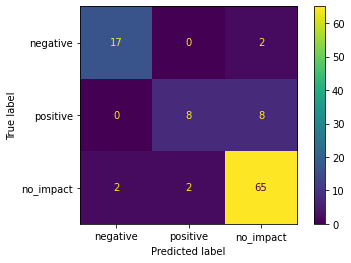

In [ ]:
print_confusion_matrix(labels, np.argmax(logits, axis=-1))